In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch.nn.functional as F
import torch_geometric
import kmbio  # fork of biopython PDB with some changes in how the structure, chain, etc. classes are defined.
import numpy as np
import pandas as pd
import proteinsolver
import modules

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import *
from torch import nn, optim
from pathlib import Path

from modules.dataset import *
from modules.utils import *
from modules.model import *
from modules.lstm_utils import *

np.random.seed(1)

### Paths

In [2]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed" / "tcr_binding"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "state_files" / "tcr_binding"

### Get metadata

In [3]:
model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
metadata

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path
0,1,AVSQSNTGKLI,ASSQLMENTEAF,NLVPMVATV,1,0,TRAV12-2,TRAJ37,TRBV4-1,TRBJ1-1,tenX,TRAV12-2*01,TRAJ37*01,TRBV4-1*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
1,2,AASEVCADYKLS,ASSYSLLRAAPNTEAF,NLVPMVATV,1,0,TRAV29DV5,TRAJ20,TRBV6-3,TRBJ1-1,tenX,TRAV29/DV5*01,TRAJ20*01,TRBV6-3*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
2,3,AGRLGAQKLV,ASSQGGRRNQPQH,NLVPMVATV,1,0,TRAV25,TRAJ54,TRBV4-2,TRBJ1-5,tenX,TRAV25*01,TRAJ54*01,TRBV4-2*01,TRBJ1-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...
3,4,AVEPLYGNKLV,ASSSREAEAF,NLVPMVATV,1,0,TRAV22,TRAJ47,TRBV7-9,TRBJ1-1,tenX,TRAV22*01,TRAJ47*01,TRBV7-9*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
4,5,ASGTYKYI,ASSQRAGRVDTQY,NLVPMVATV,1,0,TRAV19,TRAJ40,TRBV27,TRBJ2-3,tenX,TRAV19*01,TRAJ40*01,TRBV27*01,TRBJ2-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,12961,AVNSYYNQGGKLI,SVLQGSPYEQY,GILGFVFTL,1,1,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,positive,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10327,12962,AGNYGGSQGNLI,ASSIYSVNEQF,GILGFVFTL,1,1,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,positive,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10328,12966,AVGGSQGNLI,ASSVRSSYEQY,GILGFVFTL,1,1,TRAV8-6*02,TRAJ42*01,TRBV19*01,TRBJ2-7*01,positive,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10329,12968,AENGGGGADGLT,ASSIRSSYEQY,GILGFVFTL,1,1,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,positive,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...


### Make GNN embeddings

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# init proteinsolver gnn
num_features = 20
adj_input_size = 2
hidden_size = 128

gnn = Net(
    x_input_size=num_features + 1, 
    adj_input_size=adj_input_size, 
    hidden_size=hidden_size, 
    output_size=num_features
)
gnn.load_state_dict(torch.load(state_file, map_location=device))
gnn.eval()
gnn = gnn.to(device)

raw_files = np.array(metadata["path"])
targets = np.array(metadata["binder"])

dataset = ProteinDataset(processed_dir, raw_files, targets, overwrite=False)

In [5]:
def create_gnn_embeddings(dataset, processed_dir, device, gnn, embedding_size, overwrite=False):  
    if embedding_size == "128":
        out_dir = processed_dir / "gnn_out_pos_128"
        out_dir.mkdir(mode=0o775, parents=True, exist_ok=True)
    else:
        out_dir = processed_dir / "gnn_out_pos_20"
        out_dir.mkdir(mode=0o775, parents=True, exist_ok=True)
    
    chain_keys = np.array(["P", "M", "A", "B"])
    data_loader = iter(torch_geometric.loader.DataLoader(dataset, shuffle=False, batch_size=1))
    targets = list()
    for i, data in enumerate(data_loader):
        out_path = out_dir / f"data_{i}.pt"
        if not out_path.is_file() or overwrite:
            data = data.to(device)
            
            with torch.no_grad():
                if embedding_size == "128":
                    out = gnn.forward_without_last_layer(data.x, data.edge_index, data.edge_attr)
                else:
                    out = gnn(data.x, data.edge_index, data.edge_attr)
    
            # add positional encoding of chains
            positional_encoding = np.zeros((len(data.x), len(chain_keys)))
            for j, p in enumerate(data.chain_map[0]):
                positional_encoding[j][np.where(chain_keys == p)] = 1
            positional_encoding = torch.Tensor(positional_encoding)
            out = torch.cat((out, positional_encoding), dim=1)

            torch.save(out, out_path)
        targets.append([data.y])
    torch.save(targets, out_dir / f"targets.pt")

#create_gnn_embeddings(dataset, processed_dir, device, gnn, embedding_size="20", overwrite=False)
#create_gnn_embeddings(dataset, processed_dir, device, gnn, embedding_size="128", overwrite=False)

### Make LOO partitions and init dataset

In [6]:
unique_peptides = metadata["peptide"].unique()

metadata["merged_chains"] = metadata["CDR3a"] + metadata["CDR3b"]
loo_train_partitions = list()
loo_valid_partitions = list()
for pep in unique_peptides:
    valid_df = metadata[metadata["peptide"] == pep]
    valid_unique_cdr = valid_df["merged_chains"].unique()
    
    # get training rows and drop swapped data
    train_df = metadata[metadata["peptide"] != pep]
    train_df = train_df[~train_df["merged_chains"].str.contains('|'.join(valid_unique_cdr))]

    loo_train_partitions.append(list(train_df.index))
    loo_valid_partitions.append(list(valid_df.index))

dataset = LSTMDataset(
    data_dir=processed_dir / "gnn_out_pos_128", 
    annotations_path=processed_dir / "gnn_out_pos_128" / "targets.pt"
)

In [7]:
for x in [(len(x), len(y), len(x)+len(y)) for x,y in zip(loo_train_partitions, loo_valid_partitions)]:
    print(x)

(8392, 1217, 9609)
(10225, 70, 10295)
(10185, 87, 10272)
(10027, 201, 10228)
(10264, 39, 10303)
(10247, 54, 10301)
(10193, 89, 10282)
(10180, 86, 10266)
(9957, 217, 10174)
(10272, 34, 10306)
(9928, 245, 10173)
(7623, 1667, 9290)
(10203, 76, 10279)
(2020, 6223, 8243)
(10319, 7, 10326)
(10327, 4, 10331)
(10317, 8, 10325)
(10319, 7, 10326)


### LSTM params

In [82]:
class MyLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers):
        super(MyLSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            #dropout=0.7, 
        )
        self.linear_dropout = nn.Dropout(p=0.7)
        self.linear_1 = nn.Linear(hidden_dim * 2, hidden_dim)
        #self.linear_1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 1)
        
        torch.nn.init.xavier_uniform_(self.linear_1.weight)
        torch.nn.init.xavier_uniform_(self.linear_2.weight)
    
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        h_cat = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)
        #h_cat = h[-1]
        out = self.linear_1(h_cat)
        #out = self.linear_dropout(out)
        out = F.relu(out)
        out = self.linear_2(out)
        return out

# init LSTM
batch_size = 128
embedding_dim = 128 + 4 # add for for pos encoding
hidden_dim = 32
num_layers = 2
epochs = 15

### LOO training (single LSTM)

In [83]:
# touch files to ensure output
n_splits = len(unique_peptides)
save_dir = get_non_dupe_dir(out_dir)
loss_paths = touch_output_files(save_dir, "loss", n_splits)
state_paths = touch_output_files(save_dir, "state", n_splits)
pred_paths = touch_output_files(save_dir, "pred", n_splits)

i = 0
for train_idx, valid_idx in zip(loo_train_partitions, loo_valid_partitions):
    net = MyLSTM(
        embedding_dim=embedding_dim, 
        hidden_dim=hidden_dim, 
        num_layers=num_layers, 
    )
    net = net.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001) 
    
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    valid_subset = torch.utils.data.Subset(dataset, valid_idx) 
    
    net, train_losses, valid_losses = lstm_train(
        net,
        epochs,
        criterion,
        optimizer,
        train_subset, 
        valid_subset,
        batch_size,
        device,
    )
    torch.save(
        {
            "train": train_losses, 
            "valid": valid_losses
        }, 
        loss_paths[i])
    torch.save(net.state_dict(), state_paths[i])
    
    pred, true = lstm_predict(
        net,
        valid_subset,
        device,
    )     
    torch.save(
        {
            "y_pred": pred, 
            "y_true": true,
        }, 
        pred_paths[i]
    )
    
    i += 1


epoch: 11 - n: 34/66 - [===========================51%                              ]
epoch: 1 - train_loss: 0.48803042 - valid_loss: 0.45617271
epoch: 2 - train_loss: 0.43024815 - valid_loss: 0.42566077
epoch: 3 - train_loss: 0.41991639 - valid_loss: 0.42240043
epoch: 4 - train_loss: 0.40923190 - valid_loss: 0.41250174
epoch: 5 - train_loss: 0.39000373 - valid_loss: 0.40544485
epoch: 6 - train_loss: 0.37018693 - valid_loss: 0.37576206
epoch: 7 - train_loss: 0.35146756 - valid_loss: 0.35525131
epoch: 8 - train_loss: 0.33560534 - valid_loss: 0.43942900
epoch: 9 - train_loss: 0.32820741 - valid_loss: 0.33947374
epoch: 10 - train_loss: 0.32112281 - valid_loss: 0.33574466


KeyboardInterrupt: 

### Parallel LSTMs

In [33]:
class QuadLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers):
        super(QuadLSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.lstm_1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            #dropout=0.7, 
        )       
        self.lstm_2 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            #dropout=0.7, 
        )        
        self.lstm_3 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            #dropout=0.7, 
        )      
        self.lstm_4 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            #dropout=0.5, 
        )
        
        self.linear_dropout = nn.Dropout(p=0.5)
        self.linear_1 = nn.Linear(hidden_dim * 4, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 1)
        
        torch.nn.init.xavier_uniform_(self.linear_1.weight)
        torch.nn.init.xavier_uniform_(self.linear_2.weight)
    
    def forward(self, x_1, x_2, x_3, x_4):
        _, (h_1, _) = self.lstm_1(x_1)
        _, (h_2, _) = self.lstm_2(x_2)
        _, (h_3, _) = self.lstm_3(x_3)
        _, (h_4, _) = self.lstm_4(x_4)
        h_cat = torch.cat((h_1[-1], h_2[-1], h_3[-1], h_4[-1]), dim=1)
        out = self.linear_1(h_cat)
        #out = self.linear_dropout(out)
        out = F.relu(out)
        out = self.linear_2(out)
        return out

# init LSTM
batch_size = 64
embedding_dim = 128
hidden_dim = 32
num_layers = 2
epochs = 4

### LOO training (parallel LSTMs for each chain)

In [34]:
def pad_collate_chain_split(batch, pad_val=0):
    (xx, yy) = zip(*batch)
    x_1_batch = list()
    x_2_batch = list()
    x_3_batch = list()
    x_4_batch = list()
    for x in xx:
        x_1_batch.append(x[x[:,-1] == 1][:,:-4])  # slice based on positional encoding and remove encoding part
        x_2_batch.append(x[x[:,-2] == 1][:,:-4])
        x_3_batch.append(x[x[:,-3] == 1][:,:-4])
        x_4_batch.append(x[x[:,-4] == 1][:,:-4])

        x1_pad = nn.utils.rnn.pad_sequence(x_1_batch, batch_first=True, padding_value=pad_val)
        x2_pad = nn.utils.rnn.pad_sequence(x_2_batch, batch_first=True, padding_value=pad_val)
        x3_pad = nn.utils.rnn.pad_sequence(x_3_batch, batch_first=True, padding_value=pad_val)
        x4_pad = nn.utils.rnn.pad_sequence(x_4_batch, batch_first=True, padding_value=pad_val)
        yy_pad = nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=pad_val)
    return x1_pad, x2_pad, x3_pad, x4_pad, yy_pad


def lstm_quad_train(
    model,
    epochs,
    criterion,
    optimizer,
    train_data, 
    valid_data,
    batch_size,
    device,
):
    train_losses = list()
    valid_losses = list()
    
    for e in range(epochs):
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_chain_split)
        valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_chain_split)

        train_len = len(train_loader)
        valid_len = len(valid_loader)

        train_loss = 0
        model.train()
        j = 0
        for x_1, x_2, x_3, x_4, y in train_loader:    
            y = y.to(device)
            x_1 = x_1.to(device)
            x_2 = x_2.to(device)
            x_3 = x_3.to(device)
            x_4 = x_4.to(device)
            y_pred = model(x_1, x_2, x_3, x_4)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            display_func(j, train_len, e, train_losses, valid_losses)
            j += 1
            
        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for x_1, x_2, x_3, x_4, y in valid_loader:    
                y = y.to(device)
                x_1 = x_1.to(device)
                x_2 = x_2.to(device)
                x_3 = x_3.to(device)
                x_4 = x_4.to(device)
                y_pred = model(x_1, x_2, x_3, x_4)
                loss = criterion(y_pred, y)
                valid_loss += loss.item()

        train_losses.append(train_loss / train_len)
        valid_losses.append(valid_loss / valid_len)

    return model, train_losses, valid_losses


def lstm_quad_predict(model, data, device):
    data_loader = DataLoader(dataset=data, batch_size=1, shuffle=False, collate_fn=pad_collate_chain_split)
    pred = list()
    true = list()
    with torch.no_grad():
        for x_1, x_2, x_3, x_4, y in data_loader:    
            x_1 = x_1.to(device)
            x_2 = x_2.to(device)
            x_3 = x_3.to(device)
            x_4 = x_4.to(device)
            y_pred = model(x_1, x_2, x_3, x_4)
            pred.append(torch.sigmoid(y_pred))
            true.append(y)
    return torch.Tensor(pred), torch.Tensor(true)

In [35]:
#indices = np.array(metadata.index)
#n_data = len(indices)
#valid_frac = 0.2
#valid_num = int(n_data * valid_frac)
#selection = np.random.randint(0, n_data, valid_num)
#mask = np.zeros(n_data, bool)
#mask[selection] = 1
#
#loo_valid_partitions = [indices[mask]]
#loo_train_partitions = [indices[~mask]]

In [36]:
# touch files to ensure output
n_splits = len(unique_peptides)
save_dir = get_non_dupe_dir(out_dir)
loss_paths = touch_output_files(save_dir, "loss", n_splits)
state_paths = touch_output_files(save_dir, "state", n_splits)
pred_paths = touch_output_files(save_dir, "pred", n_splits)

i = 0
for train_idx, valid_idx in zip(loo_train_partitions, loo_valid_partitions):
    
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    valid_subset = torch.utils.data.Subset(dataset, valid_idx) 
    
    net = QuadLSTM(
        embedding_dim=embedding_dim, 
        hidden_dim=hidden_dim, 
        num_layers=num_layers, 
    )
    net = net.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)  # test learning rate scheduler
    
    net, train_losses, valid_losses = lstm_quad_train(
        net,
        epochs,
        criterion,
        optimizer,
        train_subset, 
        valid_subset,
        batch_size,
        device,
    )
    torch.save(
        {
            "train": train_losses, 
            "valid": valid_losses
        }, 
        loss_paths[i])
    torch.save(net.state_dict(), state_paths[i])
    
    pred, true = lstm_quad_predict(
        net,
        valid_subset,
        device,
    )     
    torch.save(
        {
            "y_pred": pred, 
            "y_true": true,
        }, 
        pred_paths[i]
    )
    break
    i += 1


epoch: 4 - n: 132/132 - [========================================================100%]
epoch: 1 - train_loss: 0.39153543 - valid_loss: 0.54873513
epoch: 2 - train_loss: 0.28565296 - valid_loss: 0.33924700
epoch: 3 - train_loss: 0.24541357 - valid_loss: 0.41481927


In [37]:
#pred, true = lstm_quad_predict(
#        net,
#        valid_subset,
#        device,
#)     
#torch.save(
#    {
#        "y_pred": pred, 
#        "y_true": true,
#    }, 
#    pred_paths[i]
#)

LOO performance of fold NLVPMVATV:
AUC=0.643566347434834
F1=0.2910321489001692


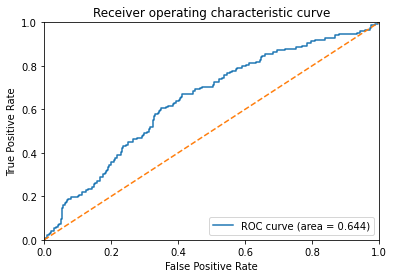

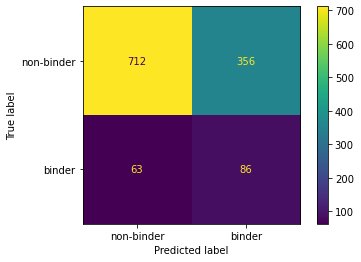

In [83]:
import matplotlib.pyplot as plt
import copy

# auc
auc = roc_auc_score(true, pred)

print(f"LOO performance of fold {unique_peptides[0]}:")
print(f"AUC={auc}")
print(f"F1={f1}")

fpr, tpr, _ = roc_curve(true, pred, pos_label=1)
plt.figure()
plt.plot(
    fpr,
    tpr,
    label="ROC curve (area = %0.3f)" % auc,
)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic curve")
plt.legend(loc="lower right")
plt.show()

# confusion matrix
labels = ["non-binder", "binder"]
pred_copy = copy.deepcopy(pred)
pred_copy[pred >= 0.12] = 1
pred_copy[pred < 0.12] = 0
cm = confusion_matrix(true, pred_copy)

# f1
f1 = f1_score(true, pred_copy)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
plot = disp.plot()
plot.figure_.show()

### Performance metrics

In [ ]:
# compute performance
labels = ["non-binder", "binder"]
performance_data = dict()
for i in range(n_splits):
    print(i)
    if i == 14 or i == 15:
        break
    data = torch.load(pred_paths[i])
    y_pred = data["y_pred"]
    y_true = data["y_true"]
    
    # confusion matrix
    y_pred_max = y_pred
    y_pred_max[y_pred >= 0.5] = 1
    y_pred_max[y_pred < 0.5] = 0
    cm = confusion_matrix(y_true, y_pred_max)

    # f1
    f1 = f1_score(y_true, y_true)

    # multiclass auc
    auc = roc_auc_score(y_true, y_pred)

    output = {
        "f1": f1,
        "auc": auc,
        "cm": cm,
        "labels": labels
    }
    
    performance_data[i] = output
performance_file = save_dir / "performance_data.pt"
torch.save(performance_data, performance_file)

In [ ]:
fold_idx = 1
data = torch.load(performance_file)[fold_idx]

cm, f1, auc = data["cm"], data["f1"], data["auc"]
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
print(f"LOO performance of fold {fold_idx}:")
print(f"AUC={auc}")
print(f"F1={f1}")